# 使用Pytorch框架

In [3]:
# import the pytorch framework
import math
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import torch.nn.functional as F

## 词嵌入

In [4]:
# 词嵌入
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        # d_model 词嵌入维度
        # vocab 字典大小
        super (Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model
    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model) # 乘以常数

In [5]:
# 测试
d_model = 512 # embedding_size
vocab = 1000
x= torch.tensor([[100, 2, 421, 508], [491, 998, 1, 221]], dtype = torch.long)# 两个四个词的句子
emb = Embeddings(d_model, vocab)
embr = emb(x)
print(embr.shape) # 2个句子，四个词的句子，512行

torch.Size([2, 4, 512])


In [6]:
embr

tensor([[[ -7.3768, -53.0558, -40.1069,  ...,  -4.2341,   5.1325, -17.0627],
         [-12.8369,  16.5664,  -8.0134,  ...,  54.1848, -17.3589,   4.2372],
         [-13.8192,  34.2724, -10.2865,  ...,  -3.3124,  -2.3546, -16.9529],
         [ -2.7785,  -1.2745,  55.6455,  ...,   6.9423,  15.4559,   7.7309]],

        [[ 63.3647,  19.0235, -10.1990,  ..., -26.4031,  21.9425, -13.4699],
         [ -6.0960, -10.1669,   5.5714,  ...,   8.5668,  12.1078, -13.5453],
         [  0.1443,  57.8225,  19.3082,  ...,  19.2952,  -7.5767,   0.1007],
         [  5.0110,  22.5033, -18.5793,  ...,   8.2812,  10.3386,  20.4813]]],
       grad_fn=<MulBackward0>)

In [7]:
# 自建词表
corpus = ["he is an old worker", "english is a useful tool", "the cinema is far away"]

In [8]:
vocab = []
for i in corpus:
    for j in i.split():
        vocab.append(j)
# 分开成单独词
vocab

['he',
 'is',
 'an',
 'old',
 'worker',
 'english',
 'is',
 'a',
 'useful',
 'tool',
 'the',
 'cinema',
 'is',
 'far',
 'away']

In [9]:
# 去重复独热编码
vocab_dict = {}
for i in enumerate(set(vocab)):
    vocab_dict[i[1]]=i[0] #按位置放入字典
vocab_dict 

{'old': 0,
 'is': 1,
 'useful': 2,
 'an': 3,
 'far': 4,
 'he': 5,
 'tool': 6,
 'a': 7,
 'cinema': 8,
 'away': 9,
 'the': 10,
 'english': 11,
 'worker': 12}

In [10]:
# 准备词嵌入
# vocab size 
# embedding dimension
embeds = nn.Embedding(len(vocab_dict), 5) 


In [11]:
# 选取句子
input_tensor = torch.tensor([vocab_dict[i] for i in corpus[0].split()], dtype = torch.long)
# 获取句子中的词在词表中的位置码
input_tensor

tensor([ 5,  1,  3,  0, 12])

In [12]:
output_tensor = embeds(input_tensor)
output_tensor 

tensor([[-0.7279,  1.2835, -0.3415,  0.2046,  1.0759],
        [-0.2866, -1.1746, -0.3594,  1.3604,  0.1719],
        [-0.1026, -2.0740, -1.3745, -0.9865, -1.1625],
        [-1.4072,  1.0669, -0.5726, -1.1552, -0.8770],
        [ 1.7803,  1.7893,  1.2278, -0.8851,  0.0580]],
       grad_fn=<EmbeddingBackward0>)

In [13]:
# N-GRAM model 假设下一个词跟前面n个词相关
test_sentences = """by order of the peaky
blinders today's weather is good"""
CONTEXT_SIZE = 2
test_sentence = test_sentences.split()
ngrams = [
    (
        [test_sentence[i-j-1] for j in range(CONTEXT_SIZE)],
        test_sentence[i]
    )
    for i in range(CONTEXT_SIZE, len(test_sentence))
]
ngrams

[(['order', 'by'], 'of'),
 (['of', 'order'], 'the'),
 (['the', 'of'], 'peaky'),
 (['peaky', 'the'], 'blinders'),
 (['blinders', 'peaky'], "today's"),
 (["today's", 'blinders'], 'weather'),
 (['weather', "today's"], 'is'),
 (['is', 'weather'], 'good')]

In [14]:
test_sentence

['by',
 'order',
 'of',
 'the',
 'peaky',
 'blinders',
 "today's",
 'weather',
 'is',
 'good']

In [15]:
# 获取词表
test_sentence
test_sentence_dict = {}
for item in enumerate(set(test_sentence)):
    test_sentence_dict[item[1]]=item[0]
test_sentence_dict

{'order': 0,
 'is': 1,
 'good': 2,
 'blinders': 3,
 'by': 4,
 'of': 5,
 'peaky': 6,
 "today's": 7,
 'weather': 8,
 'the': 9}

## NGramLanguageModeler 模型

In [16]:
# 训练词向量
class NGramLanguageModeler(nn.Module):
    # vocab_size 词表长度
    # embedding_dim 词向量维度
    # context_size 前面词数量
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)
    
    def forward(self, inputs):
        # view 维度
        embeds = self.embeddings(inputs).view(1, -1)
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

# 损失函数 负对数
loss_function = nn.NLLLoss()

### 实例化模型和训练测试

In [17]:
model = NGramLanguageModeler(len(test_sentence), embedding_dim=5, context_size=2)
optimer = optim.SGD(model.parameters(), lr=0.001)

In [18]:
# ngrams structure
ngrams

[(['order', 'by'], 'of'),
 (['of', 'order'], 'the'),
 (['the', 'of'], 'peaky'),
 (['peaky', 'the'], 'blinders'),
 (['blinders', 'peaky'], "today's"),
 (["today's", 'blinders'], 'weather'),
 (['weather', "today's"], 'is'),
 (['is', 'weather'], 'good')]

In [19]:
# test_sentence_dict structure
test_sentence_dict

{'order': 0,
 'is': 1,
 'good': 2,
 'blinders': 3,
 'by': 4,
 'of': 5,
 'peaky': 6,
 "today's": 7,
 'weather': 8,
 'the': 9}

In [20]:
for epoch in range(30):
    for i in ngrams:
        # i[0]就是x的输入特征
        # print(i[0])
        # test_sentence_dict[i]即通过词找对应的数字
        input_x = torch.tensor([test_sentence_dict[i] for i in i[0]], dtype = torch.long) #找寻词对应的数字
        output = model(input_x)
        # 归零
        model.zero_grad()
        # i[1]是正确输出
        loss = loss_function(output, torch.tensor([test_sentence_dict[i[1]]], dtype = torch.long)) #正确标签
        loss.backward()
        optimer.step()
    print("Loss:", loss)

Loss: tensor(1.9068, grad_fn=<NllLossBackward0>)
Loss: tensor(1.8760, grad_fn=<NllLossBackward0>)
Loss: tensor(1.8458, grad_fn=<NllLossBackward0>)
Loss: tensor(1.8159, grad_fn=<NllLossBackward0>)
Loss: tensor(1.7866, grad_fn=<NllLossBackward0>)
Loss: tensor(1.7577, grad_fn=<NllLossBackward0>)
Loss: tensor(1.7292, grad_fn=<NllLossBackward0>)
Loss: tensor(1.7013, grad_fn=<NllLossBackward0>)
Loss: tensor(1.6737, grad_fn=<NllLossBackward0>)
Loss: tensor(1.6467, grad_fn=<NllLossBackward0>)
Loss: tensor(1.6201, grad_fn=<NllLossBackward0>)
Loss: tensor(1.5939, grad_fn=<NllLossBackward0>)
Loss: tensor(1.5682, grad_fn=<NllLossBackward0>)
Loss: tensor(1.5429, grad_fn=<NllLossBackward0>)
Loss: tensor(1.5181, grad_fn=<NllLossBackward0>)
Loss: tensor(1.4937, grad_fn=<NllLossBackward0>)
Loss: tensor(1.4698, grad_fn=<NllLossBackward0>)
Loss: tensor(1.4462, grad_fn=<NllLossBackward0>)
Loss: tensor(1.4231, grad_fn=<NllLossBackward0>)
Loss: tensor(1.4004, grad_fn=<NllLossBackward0>)
Loss: tensor(1.3781,

In [21]:
model.embeddings.weight

Parameter containing:
tensor([[ 0.8501, -0.0337,  0.2773, -0.6345, -0.8030],
        [ 0.2423,  1.7972, -1.1990, -1.0840, -1.0940],
        [ 1.3362, -1.3035,  0.0198,  0.6043,  0.7613],
        [-1.1584, -0.1223, -0.4709,  1.5497,  0.8647],
        [ 1.6048,  1.1512,  1.2521, -0.5675, -0.0711],
        [ 0.6789, -1.7357, -0.1951, -0.5943,  1.5709],
        [ 1.5545,  0.5139, -1.5495, -0.8137,  1.0103],
        [ 1.6512,  0.3123, -0.8164,  0.7496, -1.0919],
        [-0.4720,  1.4504,  1.7520, -1.1109, -0.8282],
        [-0.7103, -1.4154, -0.0588,  0.6991,  0.8752]], requires_grad=True)

* Word2vec两个架构是CBOW, Skip gram. CBOW 是用两边的词， Skip gram使用目标词前后面的词

## 位置编码

* 一开始是按照顺序从1一个一个递增 [1, n]
* 或者在[0, 1]之间, 另外一个问题句子长度不一样，句子的位置编码就不同了
* 在transformer， 位置编码的维度和词嵌入的维度必须一样
* 位置加词嵌入的向量，有种加bias的意思，位置权重和词的特征加在一起

对于每个维度 \( i \)：

- 如果 \( i \) 是偶数（即 \( i = 2k \)），则位置编码使用正弦函数：
  $$ PE(pos, 2k) = \sin\left(\frac{pos}{10000^{2k/d_{\text{model}}}}\right) $$
- 如果 \( i \) 是奇数（即 \( i = 2k + 1 \)），则位置编码使用余弦函数：
  $$ PE(pos, 2k+1) = \cos\left(\frac{pos}{10000^{2k/d_{\text{model}}}}\right) $$


In [22]:
import numpy as np
import matplotlib.pyplot as plot

In [23]:
# 位置编码公式实现
def getPositionEncoding(squence_length, dim, n=10000):
    # squence_length 是最长句子长度
    # dim 每个词的位置向量
    PE = np.zeros(shape=(squence_length, dim))
    # 给squence_length做位置向量
    for pos in range(squence_length):
        for i in range(int(dim/2)):
            denominator = np.power(n, 2*i/dim)
            PE[pos, 2*i] = np.sin(pos/denominator)
            PE[pos, 2*i+1] = np.cos(pos/denominator)
            
    return PE

In [24]:
PE = getPositionEncoding(squence_length=50, dim=128, n=10000)
print(PE)

[[ 0.00000000e+00  1.00000000e+00  0.00000000e+00 ...  1.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [ 8.41470985e-01  5.40302306e-01  7.61720408e-01 ...  9.99999991e-01
   1.15478198e-04  9.99999993e-01]
 [ 9.09297427e-01 -4.16146837e-01  9.87046251e-01 ...  9.99999964e-01
   2.30956395e-04  9.99999973e-01]
 ...
 [ 1.23573123e-01 -9.92335469e-01  1.39920673e-01 ...  9.99980359e-01
   5.42744868e-03  9.99985271e-01]
 [-7.68254661e-01 -6.40144339e-01 -6.63571724e-01 ...  9.99979514e-01
   5.54292514e-03  9.99984638e-01]
 [-9.53752653e-01  3.00592544e-01 -9.99784705e-01 ...  9.99978652e-01
   5.65840153e-03  9.99983991e-01]]


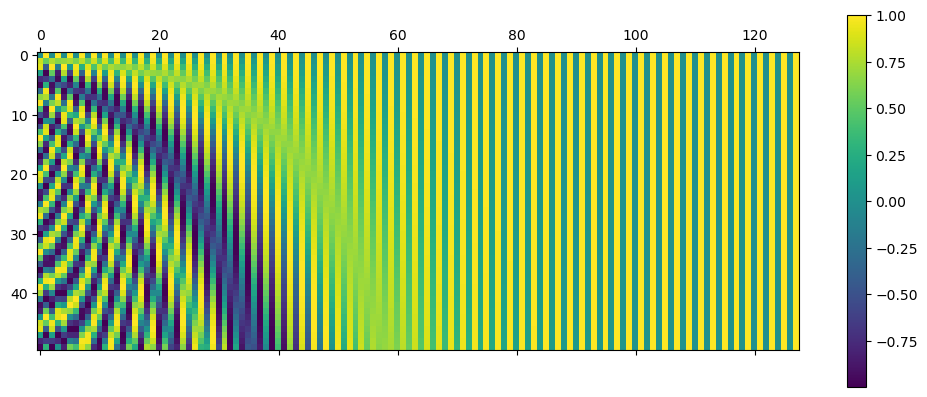

In [25]:
# 绘制位置图
caxes = plot.matshow(PE, interpolation = "nearest")
plot.colorbar(caxes)
plot.show()

## Transformer Position Encoding
* 以下代码为transformer的源代码其中的位置编码
* d_model: the dimension of embedding layer
* max_len: longest length of the sentence

In [26]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        # d_model: the dimension of embedding layer
        # dropout: 
        # max_len: longest length of the sentence
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        # unsqueeze 竖起来
        position = torch.arange(0, max_len).unsqueeze(1)
        # 使用arange计算w
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(1000.0)/d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)
    
    def forward(self, x):
        # x 就是词向量
        # variable使其参与梯度下降更新
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

## Attention注意力机制

* Query 请求
* Key 键
* Value 值
* 原理，求q和k的差值$$ softmax(-(1/2)*(q-k)**2) $$
* 点乘找值的大小找关系这个就是自注意力

### Transformer重要代码
* mask(掩码) 操作跟relu非常的相似，relu(x小于0就不要，大于0等于本身)
* mask_fill
* 任务适应性上mask图像兴趣，图像屏蔽
* 语句padding补齐

### MASKED_FILL

In [27]:
# 例子 生成一个4✖️4的张量
tensor = torch.arange(0, 16).view(4,4)
print("origin tensor: \n{}\n".format(tensor))

origin tensor: 
tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]])



In [28]:
mask = torch.eye(4, dtype=torch.bool)
print("mask tensor: \n{}\n".format(mask))

mask tensor: 
tensor([[ True, False, False, False],
        [False,  True, False, False],
        [False, False,  True, False],
        [False, False, False,  True]])



In [29]:
tensor = tensor.masked_fill(mask, 0)
print("filled tensor: \n{}\n".format(tensor))
# 用0遮住对角线的True

filled tensor: 
tensor([[ 0,  1,  2,  3],
        [ 4,  0,  6,  7],
        [ 8,  9,  0, 11],
        [12, 13, 14,  0]])



In [30]:
# Dropout是正则方法，使用时有的值会变成0别的值会变会除以（1-dropout）

### RANDN
* 其中的元素遵循标准正态分布（均值为0，标准差为1）

* torch.randn(*size, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False)
* size：指定生成的张量的形状。可以是多个参数，如 torch.randn(3, 4) 生成一个3x4的张量。
* out：可选参数，用于指定输出张量。
* dtype：指定返回张量的数据类型。
* layout：内存中的布局类型。
* device：指定张量所在的设备（CPU或GPU）。
* requires_grad：如果设置为 True，则开始跟踪在张量上的所有操作。

### VIEW

* view单独使用-1就是展平为1维
* view(m, n)就是指把这个张量变成m✖️n的张量、
* view(m, n)还添加了-1时指pytorch帮助来看弄成几维

### REGISTER_BUFFER
* Parameter与Buffer
* 模型保存下来的参数有两种一种需要更新即是Parameter
* 另一种不需要更新参数的就是Buffer（只参与梯度计算）

### VARIABLE
* 使张量必须参与反向传播，梯度下降

### MATMUL
* 使用torch.matmul( matrix1， matrix2)
* 矩阵1和矩阵2乘

### CONTIGUOUS
* 解决pytorch的不连续问题，开辟新的内存空间
* 直接变量名.contiguous()

## Transformer多头注意力代码

In [31]:
# attention function 例子
def attention(query, key, value, mask=None, dropout=None):
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1) / math.sqet(d_k)) 
    if mask is not None:
        # mask==0 是全遮挡
        scores = scores.masked_fill(mask==0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    
    if dropout is not None:
        p_attn = dropout(p_attn)
    
    return torch.matmul(p_attn, value), p_attn

In [33]:
# 深层拷贝
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [39]:
#多头注意力
class MultiHeadAttention(nn.Module):
    def __init__(self, head, embedding_dim, drop_out=0.1):
        # head number
        # dimension of the embedding layer
        # dropout
        super(MultiHeadAttention, self).__init__()
        # 确认可以被整除
        assert embedding_dim % head == 0
        self.head = head
        self.d_k = embedding_dim // head
        # acquire four linear layers (Q, K, V) and final output
        # 实例化的时候这里是 512 * 512 维度，未降维 
        # qkv的行数必须跟x的词嵌入一致(n, m) n为512， m=n/head
        self.linears = clones(nn.Linear(embedding_dim, embedding_dim), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
    
    # 前向传播
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(0)
        
        batch_size = query.size(0)
        print(query.shape)
        print(len(self.linears))
        
        # 经过线性层投影分成head个注意力
        query, key, value = [model(x).view(batch_size, -1, self.head, self.d_k).transpose(1, 2)
                             for model, x in zip(self.linears, (query, key, value))]
        # 各自注意力
        print(query.shape)
        x, self.attn = attention(query, key, value, mask = mask, dropout=self.dropout)
        # 转换回来
        print(x.shape)
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.head * self.d_k)
        # 经过最后一个线性层
        return self.linears[-1](x)

In [ ]:
# 前馈全连接层PositionwiseFeedForward


In [82]:
# 参数设置
head = 8
embedding_dim = 512
dropout= 0.2
#query = key = value = pe_result
mask = torch.zeros(8, 4, 4)
# 实例化
#mha = MultiHeadAttention(head, embedding_dim, dropout)

#mha_result = mha(query, key, value, mask)


## 子连接结构

In [53]:
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout=0.1):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(p=dropout)
        self.size = size
    
    def forward(self, x, sublayer):
        # x与经过self attention的x想加
        return x + self.dropout(subplayer(self.norm(x)))

## Encoder and Decoder编码器与解码器
* 编码器：将输入(input)转为特征(Feature)
* 解码器：将特征(Feature)转为目标(Target)
* Feature = Encoder(input)
* Target = Decoder(Feature, input)

In [64]:
# 编码器层
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        # size: 词嵌入维度
        # self_attn: 代表输入的多头注意力实例化对象
        # feed_forward 前馈全连接层实例
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
    
    def forward(self, x, mask):
        # 第一个子连接层放入注意力
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        # 第二个是前馈神经
        return self.sublayer[1](x, self.feed_forward)

In [65]:
# Encoder 编码器
# 用于设置Encoder的个数
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
    
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [66]:
# Decoder layer structure
# 解码器层
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
    
    def forward(self, x, memory, source_mask, target_mask):
        # memory 是之前的k, v
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, target))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, source_mask))
        return self.sublayer[2](x, self.feed_forward)

In [67]:
# Decoder 
class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
    
    def forward(self, x, memory, source_mask, target_mask):
        # x: 词嵌入维度
        # memory: 编码器输出张量
        # source_mask: 原数据的掩码张量
        # target_mask: 目标数据掩码张量
        for layer in self.layers:
            x = layer(x, memory, source_mask, target_mask)
        return self.norm(x)

## Softmax输出

In [68]:
class Generator(nn.Module):
    def __init__(self, d_model, vocab_size):
        super(Generator, self).__init__()
        self.project = nn.Linear(d_model, vocab_size)
    
    def forward(self, x):
        return F.softmax(self.project(x), dim=-1)